In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [4]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [5]:
# устранение выбросов
Q1 = df['CC50, mM'].quantile(0.25)
Q3 = df['CC50, mM'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['CC50, mM'] >= lower_bound) & (df['CC50, mM'] <= upper_bound)]

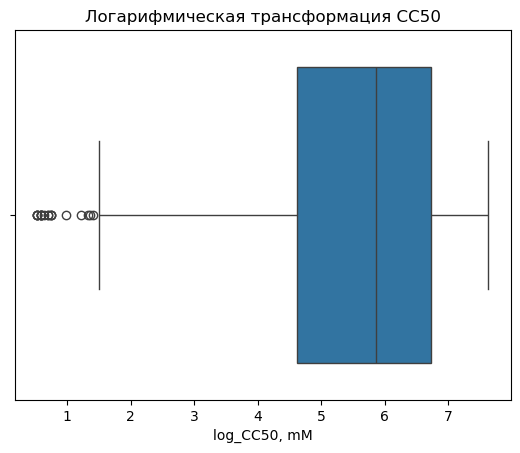

In [6]:
# Логарифмическая трансформация
df['log_CC50, mM'] = np.log(df['CC50, mM'] + 1)
sns.boxplot(x=df['log_CC50, mM'])
plt.title('Логарифмическая трансформация CC50')
plt.show()

In [7]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_CC50, mM"
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,3,0,5.173221
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,3,0,1.856738
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,3,0,5.088474
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,4,0,4.690023
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,4.943576


In [9]:
df = df.drop(df.columns[[0]], axis=1)

In [10]:
df = df.drop(df.columns[[0]], axis=1)

In [11]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_CC50, mM"
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,...,0,0,0,0,0,0,0,3,0,5.173221
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,...,0,0,0,0,0,0,0,3,0,1.856738
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,...,0,0,0,0,0,0,0,3,0,5.088474
3,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,...,0,0,0,0,0,0,0,4,0,4.690023
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,...,0,0,0,0,0,0,0,0,0,4.943576


In [20]:
# анализ мультиколинеарности и отбор фичей
target_vars = ['log_CC50, mM']
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы между признаками
corr_matrix = numeric_features.corr()
# пары признаков с высокой корреляцией (>0.8 или <-0.8)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns

vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

# корреляция признаков с целевыми переменными
corr_with_targets = pd.DataFrame(index=numeric_features.columns)
for target in target_vars:
    corr_with_targets[target] = numeric_features.corrwith(df[target])

# удаление признаков
features_to_remove = set()
for col1, col2, corr_value in high_corr_pairs:
    # проверка наличия высокой корреляции с таргетом у каждого признака
    corr_col1_targets = corr_with_targets.loc[col1].abs()
    corr_col2_targets = corr_with_targets.loc[col2].abs()

    col1_has_target_corr = any(corr_col1_targets > 0.2)
    col2_has_target_corr = any(corr_col2_targets > 0.2)
    if not col1_has_target_corr and not col2_has_target_corr:
        features_to_remove.add(col2)
print("\nПризнаки для удаления из-за мультиколлинеарности без связи с таргетом:")
for feature in features_to_remove:
    print(feature)

# итоговый набор признаков после удаления
final_features = [col for col in numeric_features.columns if col not in features_to_remove]
print("\nОставшиеся признаки после удаления:")
print(final_features)

df_final = df[final_features]

Пары признаков с высокой корреляцией (>0.8):
MaxAbsEStateIndex и MaxEStateIndex: корреляция = 1.00
MaxEStateIndex и MaxAbsEStateIndex: корреляция = 1.00
MinEStateIndex и fr_alkyl_halide: корреляция = -0.85
SPS и FractionCSP3: корреляция = 0.85
MolWt и HeavyAtomMolWt: корреляция = 1.00
MolWt и ExactMolWt: корреляция = 1.00
MolWt и NumValenceElectrons: корреляция = 0.98
MolWt и BertzCT: корреляция = 0.90
MolWt и Chi0: корреляция = 0.99
MolWt и Chi0n: корреляция = 0.93
MolWt и Chi0v: корреляция = 0.95
MolWt и Chi1: корреляция = 0.99
MolWt и Chi1n: корреляция = 0.90
MolWt и Chi1v: корреляция = 0.92
MolWt и Kappa1: корреляция = 0.96
MolWt и Kappa2: корреляция = 0.90
MolWt и LabuteASA: корреляция = 0.99
MolWt и HeavyAtomCount: корреляция = 0.99
MolWt и MolMR: корреляция = 0.96
HeavyAtomMolWt и MolWt: корреляция = 1.00
HeavyAtomMolWt и ExactMolWt: корреляция = 1.00
HeavyAtomMolWt и NumValenceElectrons: корреляция = 0.96
HeavyAtomMolWt и BertzCT: корреляция = 0.92
HeavyAtomMolWt и Chi0: коррел

In [21]:
df_final.head()

,MinAbsEStateIndex,qed,NumRadicalElectrons,BCUT2D_MWLOW,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,Kappa3,PEOE_VSA10,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_CC50, mM"
0,0.387225,0.417362,0,9.700470,0.193481,3.150503,1.164038,2.187750e+06,2.868737,0.0,...,0,0,0,0,0,0,0,3,0,5.173221
1,0.533868,0.462473,0,9.689226,0.120322,3.150503,1.080362,2.187750e+06,3.027177,0.0,...,0,0,0,0,0,0,0,3,0,1.856738
2,0.543231,0.260923,0,9.681293,-0.922902,3.214947,1.219066,8.610751e+06,3.470070,0.0,...,0,0,0,0,0,0,0,3,0,5.088474
3,0.390603,0.377846,0,9.700497,0.193510,3.179270,1.120513,3.572142e+06,3.263848,0.0,...,0,0,0,0,0,0,0,4,0,4.690023
4,0.270476,0.429038,0,9.700386,0.193687,3.337074,1.136678,1.053758e+08,3.345855,0.0,...,0,0,0,0,0,0,0,0,0,4.943576


In [22]:
# 20 самых важных признаков
X = df.drop(columns=['log_CC50, mM'])
y = df['log_CC50, mM']

importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("20 самых важных признаков для СC50 по их значимости:")
print(feature_importances.head(20))

20 самых важных признаков для СC50 по их значимости:
ExactMolWt             1.115875
MolWt                  1.104592
HeavyAtomMolWt         0.884843
Chi0                   0.768258
LabuteASA              0.746981
Chi1                   0.721373
NumValenceElectrons    0.682559
Chi0v                  0.666684
HeavyAtomCount         0.654642
Kappa1                 0.652258
Chi0n                  0.613053
MolMR                  0.611491
Chi1v                  0.599763
MaxAbsPartialCharge    0.599317
MinAbsPartialCharge    0.595152
Kappa2                 0.588092
BCUT2D_CHGLO           0.585253
MaxPartialCharge       0.584964
BCUT2D_MRLOW           0.578578
BCUT2D_LOGPLOW         0.572661
dtype: float64


In [23]:
# удаление признаков с важностью менее 0.4
features_to_keep = feature_importances[feature_importances >= 0.4].index
X_drop = X[features_to_keep]

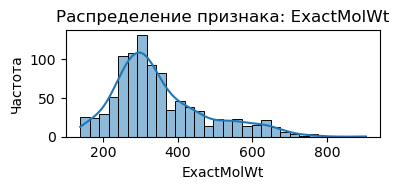

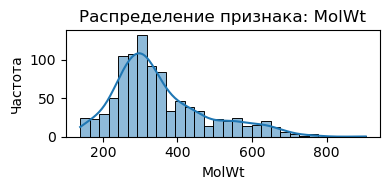

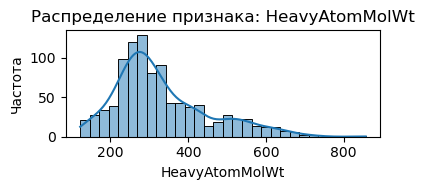

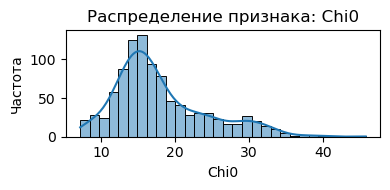

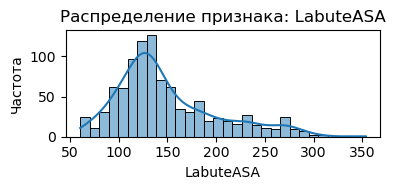

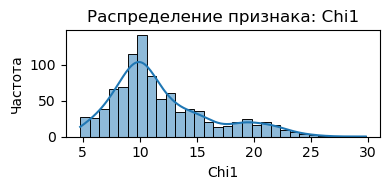

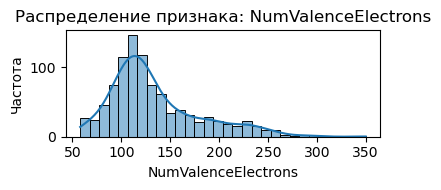

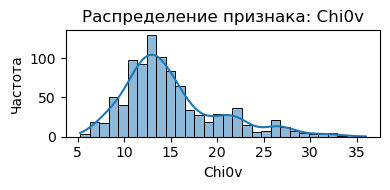

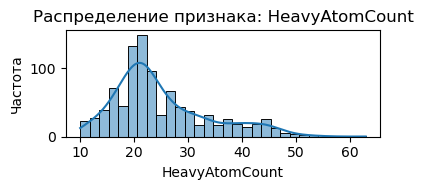

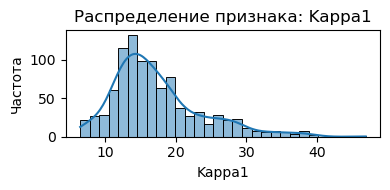

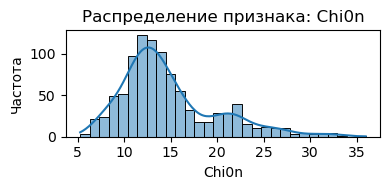

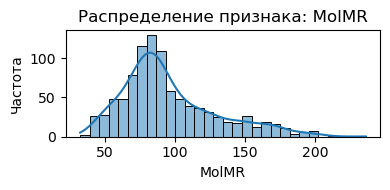

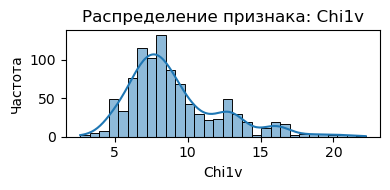

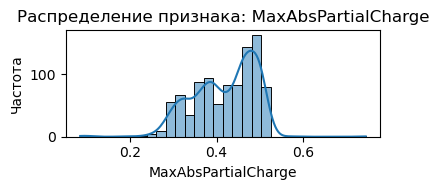

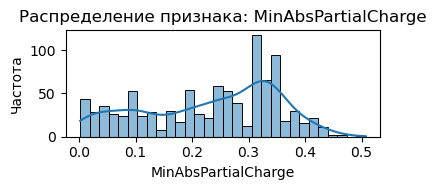

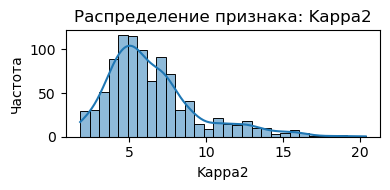

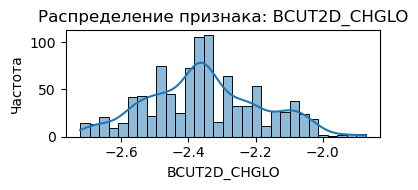

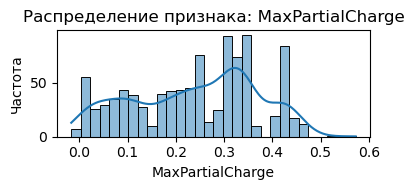

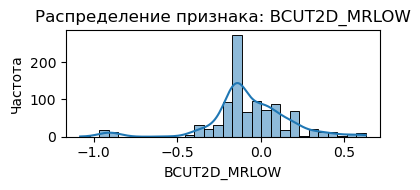

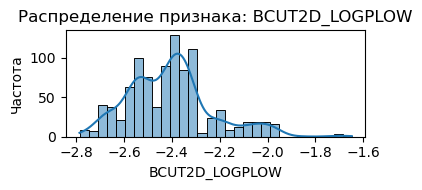

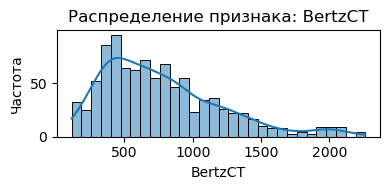

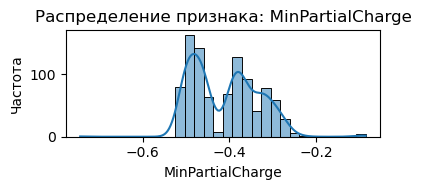

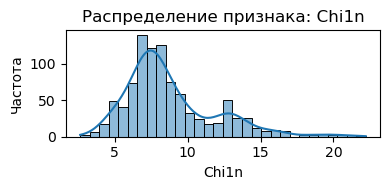

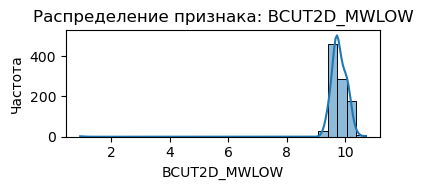

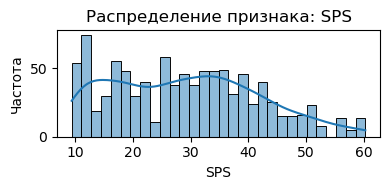

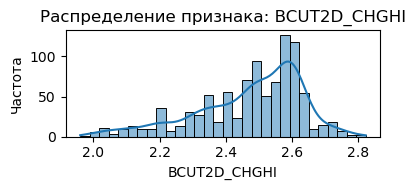

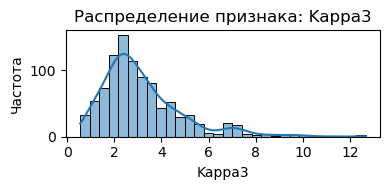

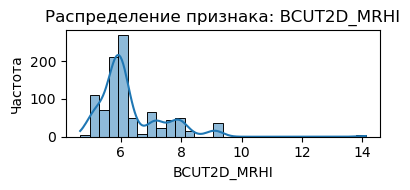

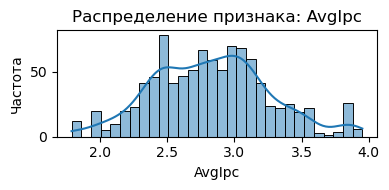

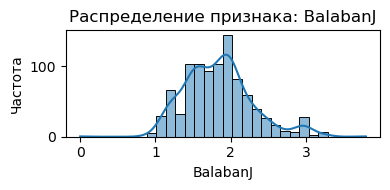

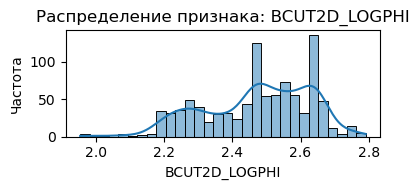

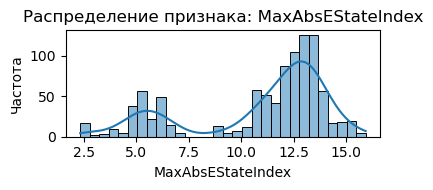

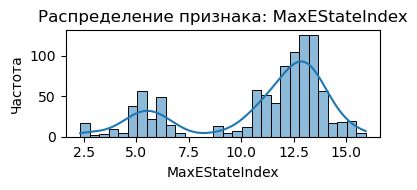

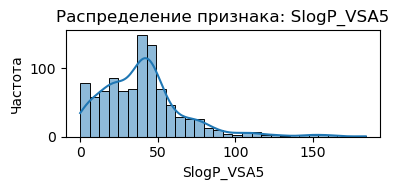

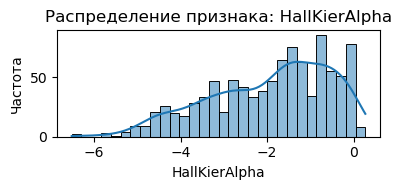

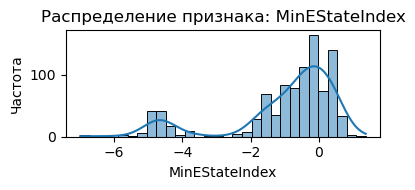

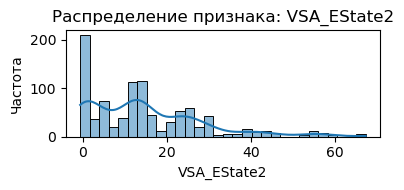

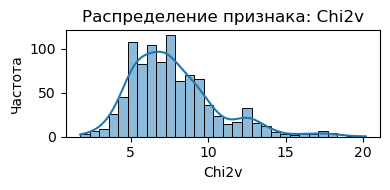

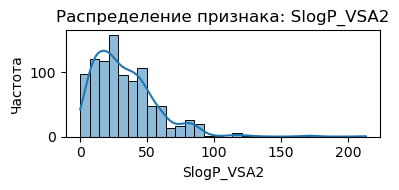

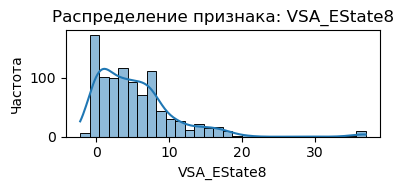

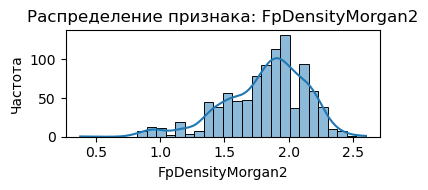

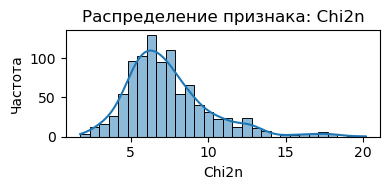

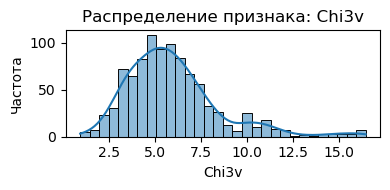

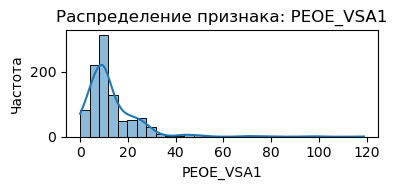

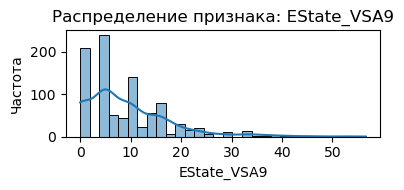

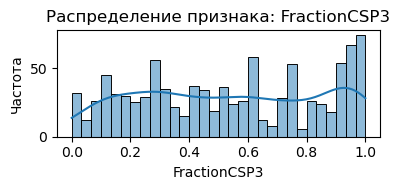

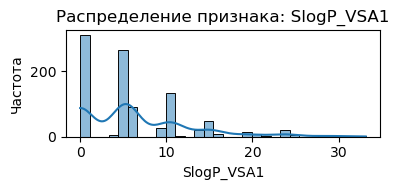

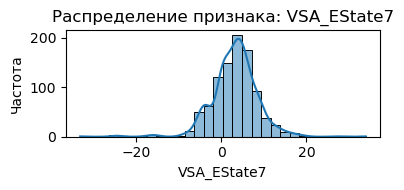

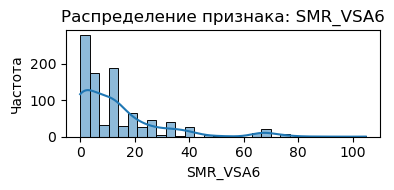

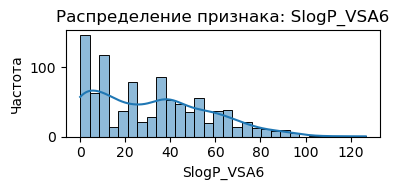

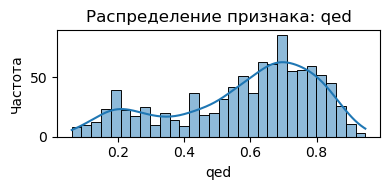

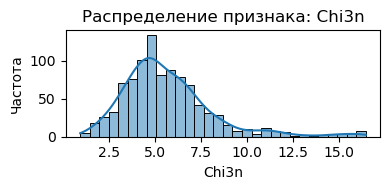

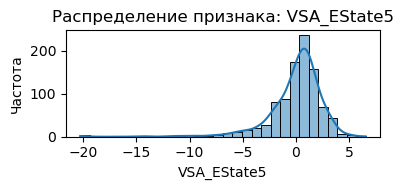

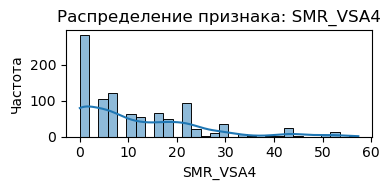

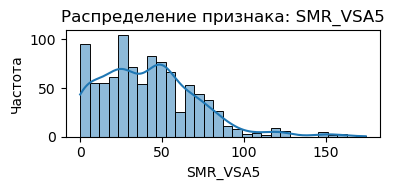

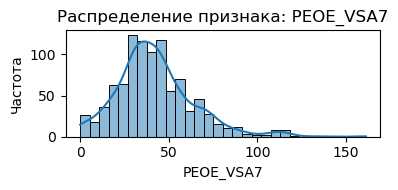

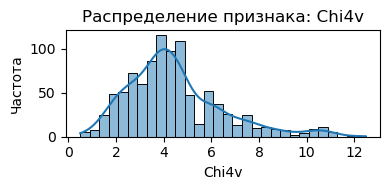

In [24]:
# построение графиков распределения оставшихся признаков
for feature in features_to_keep:
    plt.figure(figsize=(4, 2))
    sns.histplot(X_drop[feature], bins=30, kde=True)
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout() 
    plt.show()

In [25]:
# логарифмизация признаков
skewness = X_drop.skew()
print(skewness[skewness.abs() > 1])
features_to_log = skewness[skewness > 1].index

print("Признаки для логарифмирования СC50:", list(features_to_log))

for feature in features_to_log:
    min_value = X_drop[feature].min()
    if min_value <= 0:
        shift_value = abs(min_value) + 1e-9
        X_drop[feature] = np.log(X_drop[feature] + shift_value)
    else:
        X_drop[feature] = np.log(X_drop[feature])

ExactMolWt              1.013320
MolWt                   1.013184
LabuteASA               1.033318
Chi1                    1.019719
NumValenceElectrons     1.119158
Chi0v                   1.109197
HeavyAtomCount          1.010573
Kappa1                  1.141537
Chi0n                   1.147489
MolMR                   1.011557
Chi1v                   1.154385
Kappa2                  1.283310
BertzCT                 1.038477
Chi1n                   1.234558
BCUT2D_MWLOW          -14.346254
Kappa3                  1.606381
BCUT2D_MRHI             2.264857
MaxAbsEStateIndex      -1.008167
MaxEStateIndex         -1.008167
SlogP_VSA5              1.410186
MinEStateIndex         -1.541483
VSA_EState2             1.171155
Chi2v                   1.106566
SlogP_VSA2              1.764709
VSA_EState8             2.368108
Chi2n                   1.277325
Chi3v                   1.351499
PEOE_VSA1               3.361288
EState_VSA9             1.589692
SlogP_VSA1              1.214363
SMR_VSA6  

In [26]:
# замена выбросов на границы интервала (IQR) для всех признаков
for feature in X_drop.columns:
    Q1 = X_drop[feature].quantile(0.25)
    Q3 = X_drop[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_values = X_drop[feature].copy()
    X_drop.loc[X_drop[feature] < lower_bound, feature] = lower_bound
    X_drop.loc[X_drop[feature] > upper_bound, feature] = upper_bound
    
    num_lower_replacements = (before_values < lower_bound).sum()
    num_upper_replacements = (before_values > upper_bound).sum()
    
    print(f"В признаке '{feature}': заменено {num_lower_replacements} значений ниже нижней границы и {num_upper_replacements} выше верхней границы.")

В признаке 'ExactMolWt': заменено 2 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'MolWt': заменено 2 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'HeavyAtomMolWt': заменено 0 значений ниже нижней границы и 39 выше верхней границы.
В признаке 'Chi0': заменено 0 значений ниже нижней границы и 35 выше верхней границы.
В признаке 'LabuteASA': заменено 2 значений ниже нижней границы и 2 выше верхней границы.
В признаке 'Chi1': заменено 0 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'NumValenceElectrons': заменено 0 значений ниже нижней границы и 5 выше верхней границы.
В признаке 'Chi0v': заменено 3 значений ниже нижней границы и 11 выше верхней границы.
В признаке 'HeavyAtomCount': заменено 2 значений ниже нижней границы и 2 выше верхней границы.
В признаке 'Kappa1': заменено 15 значений ниже нижней границы и 12 выше верхней границы.
В признаке 'Chi0n': заменено 3 значений ниже нижней границы и 14 выше верхней границы.
В призна

In [27]:
X_drop.head()

,ExactMolWt,MolWt,HeavyAtomMolWt,Chi0,LabuteASA,Chi1,NumValenceElectrons,Chi0v,HeavyAtomCount,Kappa1,...,VSA_EState7,SMR_VSA6,SlogP_VSA6,qed,Chi3n,VSA_EState5,SMR_VSA4,SMR_VSA5,PEOE_VSA7,Chi4v
0,5.951555,5.952339,340.300,20.208896,5.156927,2.574732,5.062595,2.972177,3.332205,3.025594,...,13.258223,2.571811,9.984809,0.417362,2.369869,1.764908,3.772314,105.750639,74.032366,1.993372
1,5.961989,5.962767,340.300,20.208896,5.164439,2.574732,5.087596,2.985413,3.332205,3.052276,...,14.135381,2.571811,0.000000,0.462473,2.440004,1.914377,3.511419,116.084877,87.965867,2.101803
2,6.101347,6.102129,388.344,23.794682,5.304493,2.680731,5.225747,3.165015,3.465736,3.219920,...,14.491619,3.720383,0.000000,0.260923,2.595422,1.930720,3.511419,116.084877,74.032366,2.316518
3,5.987371,5.988157,352.311,20.916003,5.192929,2.612111,5.099866,3.007736,3.367296,3.071185,...,14.695439,2.571811,9.984809,0.377846,2.392973,1.769975,3.772314,112.171461,74.032366,2.017170
4,6.144904,6.145715,424.377,24.639617,5.356207,2.804982,5.214936,3.118732,3.555348,3.143933,...,8.627311,-20.723266,58.515746,0.429038,2.470933,1.605178,3.772314,86.488175,87.965867,2.094216


In [28]:
# стандартизация
std = StandardScaler()
std.fit(X_drop)
X_std = std.transform(X_drop)
X_std_df = pd.DataFrame(X_std, columns=X_drop.columns)
print("Стандартизированные данные:")
X_std_df.head()

Стандартизированные данные:


,ExactMolWt,MolWt,HeavyAtomMolWt,Chi0,LabuteASA,Chi1,NumValenceElectrons,Chi0v,HeavyAtomCount,Kappa1,...,VSA_EState7,SMR_VSA6,SlogP_VSA6,qed,Chi3n,VSA_EState5,SMR_VSA4,SMR_VSA5,PEOE_VSA7,Chi4v
0,0.420323,0.419871,0.109874,0.395905,0.634166,0.455512,0.677089,0.970242,0.502740,0.688536,...,2.113293,0.625732,-0.871177,-0.760902,1.788863,0.815368,0.755123,2.290214,1.638311,1.336058
1,0.451081,0.450604,0.109874,0.395905,0.656888,0.455512,0.754409,1.011021,0.502740,0.765941,...,2.299335,0.625732,-1.271094,-0.550962,1.963961,0.891590,0.730524,2.657470,2.339045,1.580612
2,0.861894,0.861342,0.527671,0.993847,1.080567,0.758482,1.181658,1.564360,0.894113,1.252291,...,2.374892,0.733990,-1.271094,-1.488947,2.351971,0.899924,0.730524,2.657470,1.638311,2.064879
3,0.525906,0.525435,0.214323,0.513818,0.743076,0.562352,0.792356,1.079794,0.605591,0.820800,...,2.418122,0.625732,-0.871177,-0.944805,1.846545,0.817952,0.755123,2.518396,1.638311,1.389732
4,0.990294,0.989801,0.841019,1.134743,1.237009,1.113621,1.148224,1.421764,1.156761,1.031848,...,1.131090,-1.569948,1.072613,-0.706561,2.041176,0.733913,0.755123,1.605668,2.339045,1.563501


In [29]:
# нормализация
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_drop)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_drop.columns)
print("Нормализованные данные:")
X_normalized_df.head()

Нормализованные данные:


,ExactMolWt,MolWt,HeavyAtomMolWt,Chi0,LabuteASA,Chi1,NumValenceElectrons,Chi0v,HeavyAtomCount,Kappa1,...,VSA_EState7,SMR_VSA6,SlogP_VSA6,qed,Chi3n,VSA_EState5,SMR_VSA4,SMR_VSA5,PEOE_VSA7,Chi4v
0,0.581576,0.581530,0.461612,0.532910,0.622934,0.578134,0.630464,0.710207,0.604253,0.647914,...,0.930864,0.918050,0.095509,0.403059,0.862394,0.658851,0.988819,0.910977,0.841603,0.790803
1,0.587684,0.587632,0.461612,0.532910,0.627437,0.578134,0.646193,0.718712,0.604253,0.663912,...,0.967810,0.918050,0.000000,0.453877,0.897913,0.674667,0.978288,1.000000,1.000000,0.844364
2,0.669270,0.669182,0.563254,0.679103,0.711391,0.638677,0.733105,0.834120,0.683199,0.764431,...,0.982814,0.963315,0.000000,0.226829,0.976622,0.676397,0.978288,1.000000,0.841603,0.950427
3,0.602544,0.602489,0.487023,0.561739,0.644515,0.599484,0.653912,0.733056,0.625000,0.675250,...,0.991399,0.918050,0.095509,0.358544,0.874095,0.659387,0.988819,0.966288,0.841603,0.802558
4,0.694769,0.694686,0.639486,0.713552,0.742391,0.709644,0.726303,0.804379,0.736180,0.718870,...,0.735814,0.000000,0.559726,0.416213,0.913577,0.641948,0.988819,0.745043,1.000000,0.840616


In [30]:
# разделение датасета на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (817, 57), (817,)
Train dataset size: (145, 57), (145,)


### Обучение моделей

In [31]:
models = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'KNN (KNeighborsRegressor)': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'HistGradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', HistGradientBoostingRegressor(random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'CatBoost Regressor': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', CatBoostRegressor(
            random_seed=42,
            verbose=0 
        ))
    ])
}

# обучение и оценка моделей
results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")

# подбор гиперпараметров для лучшей модели
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.1],
}

grid_search_cb = GridSearchCV(
    models['CatBoost Regressor'],
    param_grid_cb,
    cv=5,
    scoring='neg_mean_squared_error'
)

Linear Regression: MSE = 1.93, MAE = 1.08, R2 = 0.02
Ridge Regression: MSE = 1.83, MAE = 1.07, R2 = 0.07
KNN (KNeighborsRegressor): MSE = 1.06, MAE = 0.74, R2 = 0.46
Random Forest: MSE = 1.08, MAE = 0.75, R2 = 0.45
Gradient Boosting: MSE = 1.07, MAE = 0.77, R2 = 0.46
HistGradientBoosting: MSE = 1.06, MAE = 0.72, R2 = 0.46
AdaBoost: MSE = 1.46, MAE = 1.00, R2 = 0.26
XGBoost: MSE = 1.15, MAE = 0.73, R2 = 0.41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12582
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 57
[LightGBM] [Info] Start training from score 5.453635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

╒═══════════════════════════╤════════╤════════╤════════╕
│                           │    MSE │    MAE │     R2 │
╞═══════════════════════════╪════════╪════════╪════════╡
│ Linear Regression         │ 1.9271 │ 1.0795 │ 0.0225 │
├───────────────────────────┼────────┼────────┼────────┤
│ Ridge Regression          │ 1.8275 │ 1.0721 │ 0.0730 │
├───────────────────────────┼────────┼────────┼────────┤
│ KNN (KNeighborsRegressor) │ 1.0588 │ 0.7409 │ 0.4629 │
├───────────────────────────┼────────┼────────┼────────┤
│ Random Forest             │ 1.0759 │ 0.7498 │ 0.4543 │
├───────────────────────────┼────────┼────────┼────────┤
│ Gradient Boosting         │ 1.0740 │ 0.7698 │ 0.4552 │
├───────────────────────────┼────────┼────────┼────────┤
│ HistGradientBoosting      │ 1.0604 │ 0.7218 │ 0.4621 │
├───────────────────────────┼────────┼────────┼────────┤
│ AdaBoost                  │ 1.4639 │ 1.0015 │ 0.2574 │
├───────────────────────────┼────────┼────────┼────────┤
│ XGBoost                   │ 1

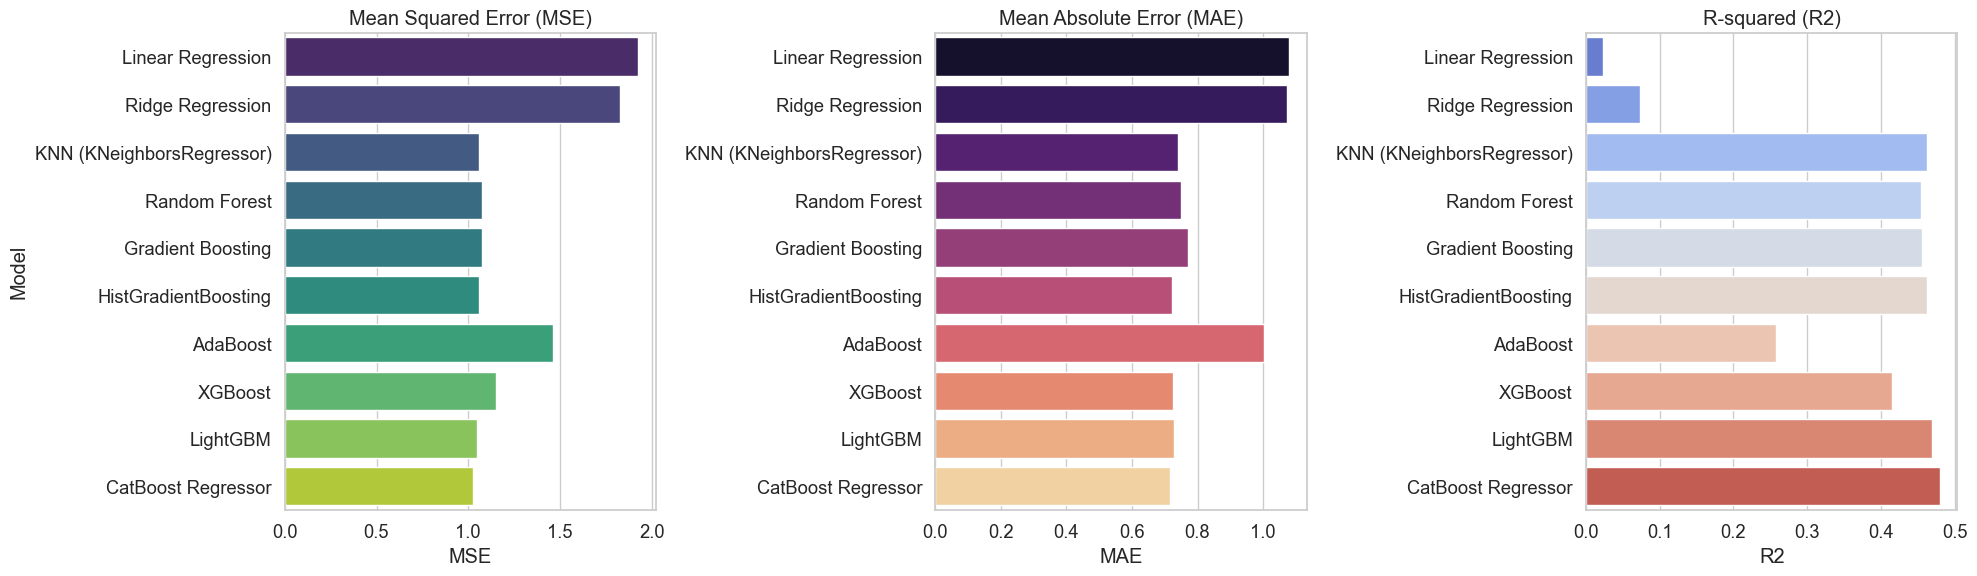

In [32]:
# визуализация результатов
results_df = pd.DataFrame(results).T  
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


results_df = pd.DataFrame(results).T 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(
    x='MSE',
    y=results_df.index,
    data=results_df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')

sns.barplot(
    x='MAE',
    y=results_df.index,
    data=results_df,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

sns.barplot(
    x='R2',
    y=results_df.index,
    data=results_df,
    ax=axes[2],
    palette='coolwarm'
)
axes[2].set_title('R-squared (R2)')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [33]:
# вычисление MAPE
results_mape = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_mape.append({'Модель': name, 'MAPE': mape})

results_df = pd.DataFrame(results_mape).sort_values(by='MAPE')

print(results_df.to_string(index=False))

                   Модель     MAPE
                  XGBoost 0.157515
       CatBoost Regressor 0.157634
                 LightGBM 0.158890
     HistGradientBoosting 0.159957
            Random Forest 0.165655
KNN (KNeighborsRegressor) 0.167869
        Gradient Boosting 0.171199
                 AdaBoost 0.214559
         Ridge Regression 0.242588
        Linear Regression 0.245455


### Побдор гиперпараметров

In [34]:
# подбор гиперпараметров
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'KNN (KNeighborsRegressor)': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'model__max_iter': [100, 200],
        'model__max_depth': [None, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1]
    },
    'CatBoost Regressor': {
        'model__iterations': [100, 200],
        'model__depth': [4, 6],
        'model__learning_rate': [0.01, 0.1]
    }
}

results = []

for name in models:
    print(f"\nОбучение и подбор гиперпараметров для {name}...")
    
    grid = GridSearchCV(
        models[name],
        param_grids.get(name, {}),
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
     })

results_df = pd.DataFrame(results)
results_df['MSE'] = results_df['MSE'].round(3)
results_df['MAE'] = results_df['MAE'].round(3)
results_df['R2'] = results_df['R2'].round(3)

results_df['Best Params'] = results_df['Best Params'].apply(lambda x: str(x))

print("\nРезультаты моделей:")
print(tabulate(results_df.sort_values(by='R2'), headers='keys', tablefmt='fancy_grid', showindex=False))


Обучение и подбор гиперпараметров для Linear Regression...

Обучение и подбор гиперпараметров для Ridge Regression...

Обучение и подбор гиперпараметров для KNN (KNeighborsRegressor)...

Обучение и подбор гиперпараметров для Random Forest...

Обучение и подбор гиперпараметров для Gradient Boosting...

Обучение и подбор гиперпараметров для HistGradientBoosting...

Обучение и подбор гиперпараметров для AdaBoost...

Обучение и подбор гиперпараметров для XGBoost...

Обучение и подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12582
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 57
[LightGBM] [Info] Start training from score 5.453635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga